# Model Output

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from xmitgcm import open_mdsdataset
import gsw as gsw
import matplotlib.pyplot as plt

## Load Output Data

In [2]:
model_run = "MS001"
output_dir = "../MITgcm/so_plumes/" + model_run
ds = open_mdsdataset(output_dir, prefix = ['Eta', 'U', 'W', 'T', 'V', 'S', 'PH'], delta_t = 3600, geometry = "cartesian")

/albedo/home/maschr005/.conda/envs/mitgcm_output/lib/python3.12/site-packages/xmitgcm/mds_store.py:289: FutureWarning: In a future version, xarray will not decode the variable 'time' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds['time'] = xr.decode_cf(ds[['time']])['time']
/albedo/home/maschr005/.conda/envs/mitgcm_output/lib/python3.12/site-packages/xmitgcm/mds_store.py:289: FutureWarning: In a future version, xarray will not decode the variable 'time' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead i

## Center Grid Column

In [44]:
def single_column_time_evol(ds, var:str, center = True, x=None, y=None, time_unit = "D", model_run="", ax = None, *args):
    '''
    Plot time evolution of given variable. If center = true, the center column is plotted. Otherwise x and y must be specified.
    
    Parameters:
        ds: dataset (mitgcm output)
        var: variable to plot
        center: Plot center column?
        x,y: x and y coordinate of column to plot
        time_unit: Time unit for plotting. "D" for day. "h" for hours.
        model_run: Specify if the model run should be displayed in the title.
        ax: Specify, if the plot should be created on a specific pre-created axes. This can be used to make a figure with multiple plots.
    Returns:
        fig, ax
    '''
    
    if center == True:
        # find dimensions
        Nx = len(ds.XC)
        Ny = len(ds.YC)

        # center cell indizes
        x = int(Nx/2)
        y = int(Ny/2)
    
    # reduce dataset to specific column
    col = ds.isel(XC = int(Nx/2), XG = int(Nx/2), YC = int(Ny/2), YG = int(Ny/2))

    # convert time coordinate from timedelta64[ns] to float64 in given unit
    col["time"] = col.time / np.timedelta64(1, time_unit)

    if ax == None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    # plot hovmöller, mind the transpose (.T)
    pcm = ax.pcolormesh(col["time"], col["Z"], col[var].T, shading = "nearest", *args)

    # labels
    xlabel = "time ["+ time_unit + "]"
    ylabel = ds["Z"].standard_name + " [" + ds["Z"].units +"]"
    cbarlabel = "[" + ds[var].units +"]"
    title = model_run + "\n" + ds[var].long_name

    # set axis labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # make colorbar
    fig.colorbar(pcm, label = cbarlabel)

    # title
    ax.set_title(title)

    return fig,ax

Text(0.5, 0.98, 'Model Run MS001\n Center Grid Column')

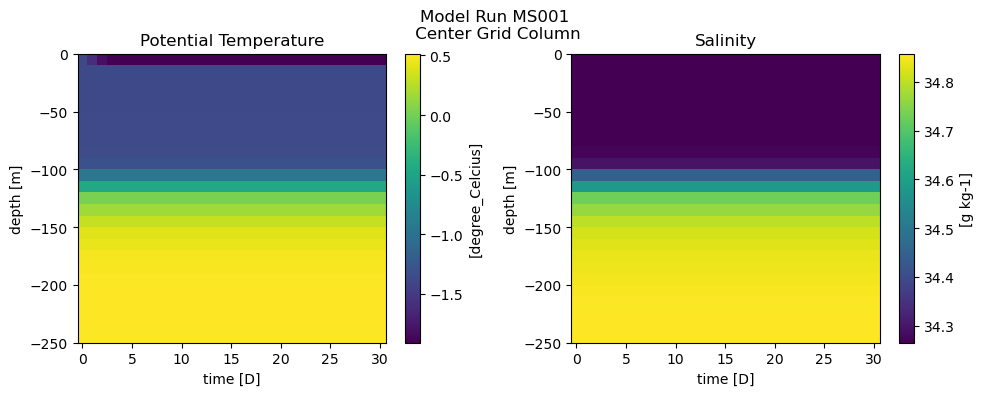

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

single_column_time_evol(ds, "T", ax = axs[0])
single_column_time_evol(ds, "S", ax = axs[1])

fig.tight_layout()
fig.suptitle("Model Run " + model_run + "\n Center Grid Column")

## 3D Cube

## 3D Crossection